In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
df = pd.read_csv('Data/all_20000_posts.csv', low_memory=False)
df.drop(columns=('Unnamed: 0'), inplace=True)
df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,crosspost_parent,crosspost_parent_list,edited,poll_data,suggested_sort,is_gallery,author_flair_template_id,link_flair_css_class,gallery_data,media_metadata
0,[],False,amnesiac7,NaN,[],NaN,text,t2_7hi8y,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Bonsai37,NaN,[],NaN,text,t2_8iqzl6l8,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,progress18,NaN,[],NaN,text,t2_nkk56,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Maxcactus,NaN,[],NaN,text,t2_1vwn,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,SLeeCunningham,NaN,[],NaN,text,t2_6b4upjaa,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df[['title', 'selftext', 'subreddit', 'created_utc']]

,title,selftext,subreddit,created_utc
0,Democrats Finally Unite—to Mock Kevin McCarthy...,NaN,Liberal,1637336367
1,What is critical race theory?,[removed],Liberal,1637332712
2,US Postal Service board chair expected to be r...,NaN,Liberal,1637330958
3,Analysis | The ugly Paul Gosar debate,NaN,Liberal,1637322475
4,Could It Be That Repeated Exposure To Hand San...,NaN,Liberal,1637297933
...,...,...,...,...
19992,Journalist Butchery of School Board Protests U...,NaN,Conservative,1635546280
19993,Biden tours Rome with 85-vehicle motorcade ahe...,NaN,Conservative,1635546050
19994,Photos: AT&amp;T Board Of Directors Which Is P...,NaN,Conservative,1635545972
19995,Think this is the first time Democrats faked a...,NaN,Conservative,1635545803


In [7]:
df['selftext'].isna().sum()

15196

In [8]:
df['selftext'] = df['selftext'].fillna('')


In [9]:
df['title_and_st'] = df['title'] + df['selftext']

In [10]:
df.duplicated(subset=None, keep='first').sum()

0

In [11]:
# Making the Liberal posts be postive and Conservative negative (showing my political bias here haha)

df['subreddit'] = df['subreddit'].map({'Liberal':1, "Conservative":0})

In [12]:
X = df['title_and_st']
y = df['subreddit']

In [13]:
y.value_counts(normalize=True)

1    0.500025
0    0.499975
Name: subreddit, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('model', LogisticRegression())]
)

In [17]:
params = {
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1,2)],
    'tvec__min_df': [1],
    'tvec__max_df':[.2],
    'tvec__max_features': [4000],
    'tvec__binary': [True],
    'model__max_iter':[1000, 3000, 5000]
}

gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.7585511170390131


{'model__max_iter': 1000,
 'tvec__binary': True,
 'tvec__max_df': 0.2,
 'tvec__max_features': 4000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

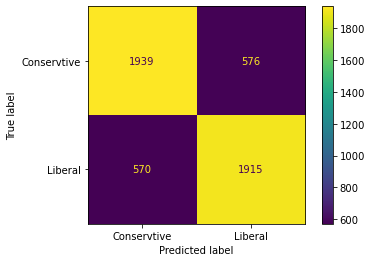

In [28]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['Conservtive', 'Liberal'])
plt.savefig('TF-IDF with untuned Logreg');

In [20]:
import sklearn.metrics as metrics

In [21]:
preds = gs.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).flatten()

### Sensitvity (recall)

In [22]:
recall = metrics.recall_score(y_test, preds)
recall

0.7706237424547284

### Precision

In [23]:
precision = metrics.precision_score(y_test, preds)
precision

0.7687675632276194

### What posts were predicted to be in the Conserative(0) subreddit but were actually in the Liberal(1) subreddit?

In [26]:
preds = gs.predict(X_test)

In [27]:
X_test[(y_test != preds) & (preds == 0)]

1087             Snowflakes is a terrible song (for 2021)
4936    Biden Faces a Minefield in New Diplomacy with ...
1202    Conservatives Are Asking You To Disbelieve You...
351             To the West Virginians of Reddit[removed]
5833    Anyone else love old music? As they say, somet...
                              ...                        
8164    Kamala Harris is Joe Biden's running mate: Liv...
5826                         What happened to us[removed]
3761              Why does this not surprise me?[removed]
1266    Great video explaining Totalitarianism. Scary ...
5861    Buy Zopiclone 7.5 mg Next Day Delivery UK | Di...
Name: title_and_st, Length: 570, dtype: object